In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy import linalg
from scipy import stats
from scipy import optimize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
def PCA(data_arr, n):
    """Takes in a non-standardized data array and performs PCA using SVD. Data should be in tidy format,
    with rows as observations and columns as variables"""
    num_rows = data_arr.shape[0]
    # Center the data
    centroid = np.mean(data_arr, axis=0)
    X_star = data_arr-centroid
    
    # Do SVD
    U, s, V_T = linalg.svd(X_star)
    eig_vectors = np.transpose(V_T)
    eig_vals = np.divide(s**2, num_rows-1)
    
    # Get the data projected into the number of PCA components specified
    PCA_data = np.matmul(X_star, eig_vectors[:,0:(n)])
    
    return PCA_data, eig_vectors, eig_vals, s, U, centroid

def plot_cluster_data(data, cluster_labels, plot_label_type):

    plt.figure(figsize=(15,15))
    
    clusters = np.unique(cluster_labels)
    
    if len(clusters) <= 16:
        colors = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]
        
    else:
        colors = cm.tab20(np.linspace(0, 1, len(clusters)))
    
    for cluster in clusters:
        plot_data_idx = (cluster_labels == cluster)
        plot_data = data[plot_data_idx,:]
        plt.scatter(plot_data[:,0], plot_data[:,1], marker='o', alpha=0.8, color=colors[cluster])
    
    if plot_label_type == "PCA":
        plt.title("Cluster data projected into first 2 PCs")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        

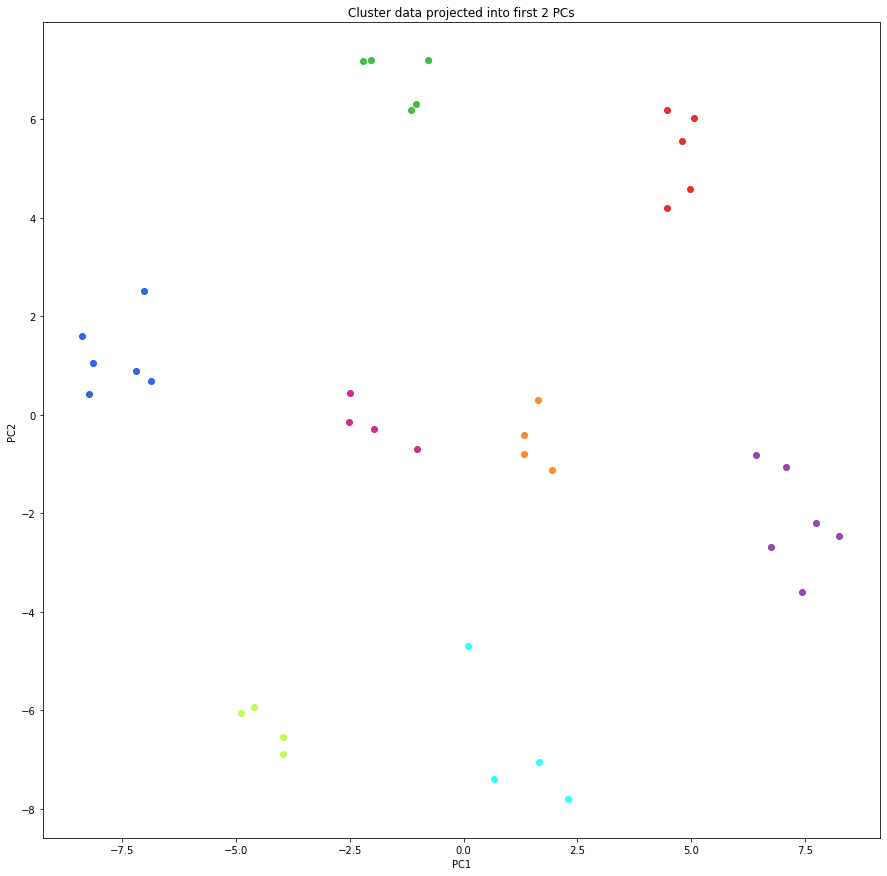

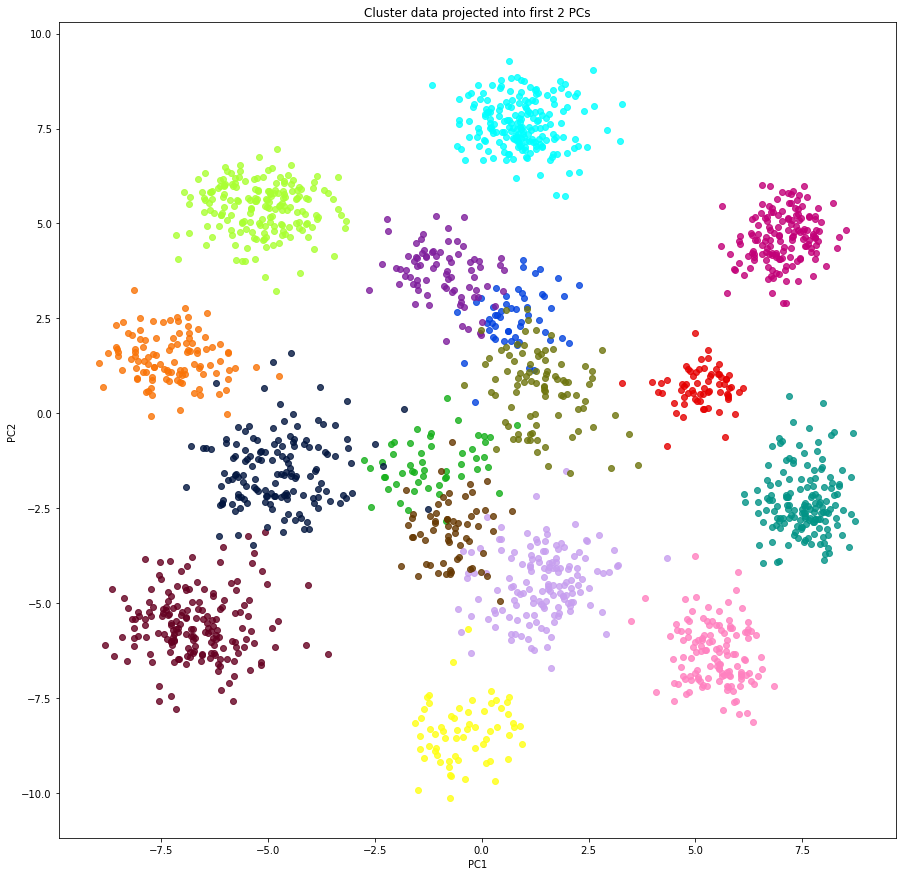

In [3]:
small_data = pd.read_csv("w11-data-small.tbl", header=0, delim_whitespace=True)
small_data_labels = small_data["type"].values
small_log_counts = np.log(small_data.drop("type", axis=1).values+1)

large_data = pd.read_csv("w11-data-large.tbl", header=0, delim_whitespace=True)
large_data_labels = large_data["type"].values
large_log_counts = np.log(large_data.drop("type", axis=1).values+1)

small_PCA_data = PCA(small_log_counts, 3)[0]
large_PCA_data = PCA(large_log_counts, 4)[0]

plot_cluster_data(small_PCA_data, small_data_labels, plot_label_type="PCA")
plot_cluster_data(large_PCA_data, large_data_labels, plot_label_type="PCA")

## Part 2

In [4]:
def get_sigmas(perp, data, dist_mat):
    
    sigma_list = []
    for r_idx in range(data.shape[0]):
        
        dist_vec = dist_mat[r_idx].flatten()
        
        # Initialize the bracketing end points 
        a, b = 1, 1
        while sigma_cost_func(a, dist_vec, perp) >= 0: a /= 2
        while sigma_cost_func(b, dist_vec, perp) <= 0: b *= 2
            
        # Use scipy_bisect to find the best sigma for this row and store it
        sigma = optimize.bisect( sigma_cost_func, a, b, args=(dist_vec,perp) )
        sigma_list.append(sigma)
        
    return sigma_list

def sigma_cost_func(sigma, dist_vec, desired_perp):
    # find the diff between actual and desired perp for a given row's sigma
    
    p_vec = np.array([calc_p_numer(dist, sigma) for dist in dist_vec])
    p_vec = np.divide(p_vec, np.sum(p_vec)) # I removed the -1 because it does not work for the numerator
    
    pos_p_vec = p_vec[p_vec>0]
    H = -np.sum( np.asarray([p*np.log2(p) for p in pos_p_vec]) )
    
    actual_perp = 2**H
    
    return actual_perp-desired_perp

def calc_P_mat(dist_mat, sigma_vec):

        
    # Get all of the p_{j|i} into a nxn matrix 
    P_mat = np.asarray( [calc_p_numer(dist, sigma_vec[r_idx]) for r_idx in range(dist_mat.shape[0]) 
                       for dist in dist_mat[r_idx,:]] ).reshape(dist_mat.shape[0],dist_mat.shape[0])
    P_mat = np.divide(P_mat, P_mat.sum(axis=1))
    
    # Now create the symmetric probability matrix for T-SNE
    P_mat = np.divide( np.add(P_mat, np.transpose(P_mat)), 2*dist_mat.shape[0] )
 
    return P_mat
    
def calc_p_numer(dist, sigma):
    
    if dist == 0: return 0
    
    else: result = np.exp(-1*np.square(dist)/(2*np.square(sigma)))
    
    return result

In [5]:
def calc_KL_dist(Y_mat, P_mat):
    num_rows = P_mat.shape[0]
    Y_mat = Y_mat.reshape(num_rows, 2)
    
    dist_list = [distance.euclidean(row_1, row_2) for row_1 in Y_mat for row_2 in Y_mat]
    dist_mat = np.asarray(dist_list).reshape(num_rows, num_rows)
    
    # Get all of the q_{j|i} into a nxn matrix 
    
    #NOTE the distances squared are so small that they are basically zero, so all of the numerators are
    # then as you go to get the Q_mat, you end up with a nearly uniform matrix. This might be wrong, like
    # maybe we should use log calculations to keep track of the small initial differences
    Q_mat = np.true_divide( 1, (np.square(dist_mat)+1) )
    np.fill_diagonal(Q_mat, 0)
    Q_mat = np.true_divide( Q_mat, Q_mat.sum() ) # temp removed a subtract 1
    
    # Ignore divide by zero warnings when dividing by zero or taking the log, set all nans to zero to fix
    with np.errstate(divide="ignore", invalid="ignore"):
        KL_dist_mat = np.multiply( P_mat, np.log(np.true_divide(P_mat, Q_mat)) )
        KL_dist_mat = np.nan_to_num(KL_dist_mat)
        
    KL_dist = KL_dist_mat.sum()
    grad_list = []
    
    for i in range(num_rows):
        j_1_term_list = []
        j_2_term_list = []
        for j in range(num_rows):
            p_q_diff = P_mat[i,j] - Q_mat[i,j]
            y_1_diff = Y_mat[i,0] - Y_mat[j,0]
            y_2_diff = Y_mat[i,1] - Y_mat[j,1]
            y_dist = np.true_divide( 1, 1+np.square(dist_mat[i,j]) )
            
            j_1_term_list.append( p_q_diff*y_1_diff*y_dist )
            j_2_term_list.append( p_q_diff*y_2_diff*y_dist )
            
        grad_list.append(4*sum(j_1_term_list))
        grad_list.append(4*sum(j_2_term_list))
        
    return KL_dist, np.asarray(grad_list).flatten()

In [26]:
dist_list = [distance.euclidean(row_1, row_2) for row_1 in small_log_counts for row_2 in small_log_counts]
dist_mat = np.asarray(dist_list).reshape(small_log_counts.shape[0], small_log_counts.shape[0])

sigma_list = get_sigmas(15, small_log_counts, dist_mat)

P_mat = calc_P_mat(dist_mat, sigma_list)

In [27]:
#NOTE this is not actually getting any smaller. Need to check the gradient function to make sure it 
# correct. After that, check the calculation of the KL_dist

#NOTE I am temporarily ignoring the gradient to see if it works without it, in which case the gradient
# is the problem. After doing this, the success returned true but it did not seem to work as the initial 
# points did not move at all
best = 100
vals = -1

for i in range(200):
    Y_mat = np.random.normal( 0., 1e-4, (38, 2) )
    result = optimize.minimize(calc_KL_dist, Y_mat.flatten(), args=(P_mat), jac=True)
    
    if result.fun < best:
        best = result.fun
        vals = result.x
        print(result.message)
        print(best)


Optimization terminated successfully.
0.9112894288952265
Optimization terminated successfully.
0.9112894236497431
Desired error not necessarily achieved due to precision loss.
0.9112660785572589
Desired error not necessarily achieved due to precision loss.
0.91124887120855


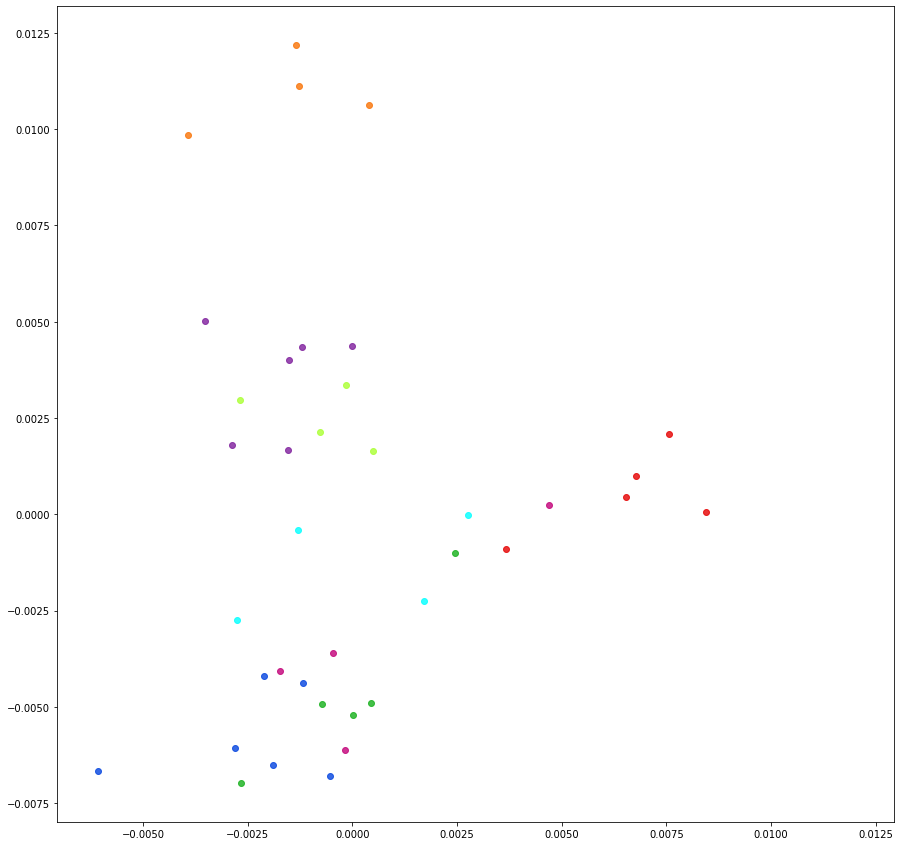

In [28]:
vals = vals.reshape(38,2)
plot_cluster_data(vals, small_data_labels, plot_label_type=False)

## Part 3

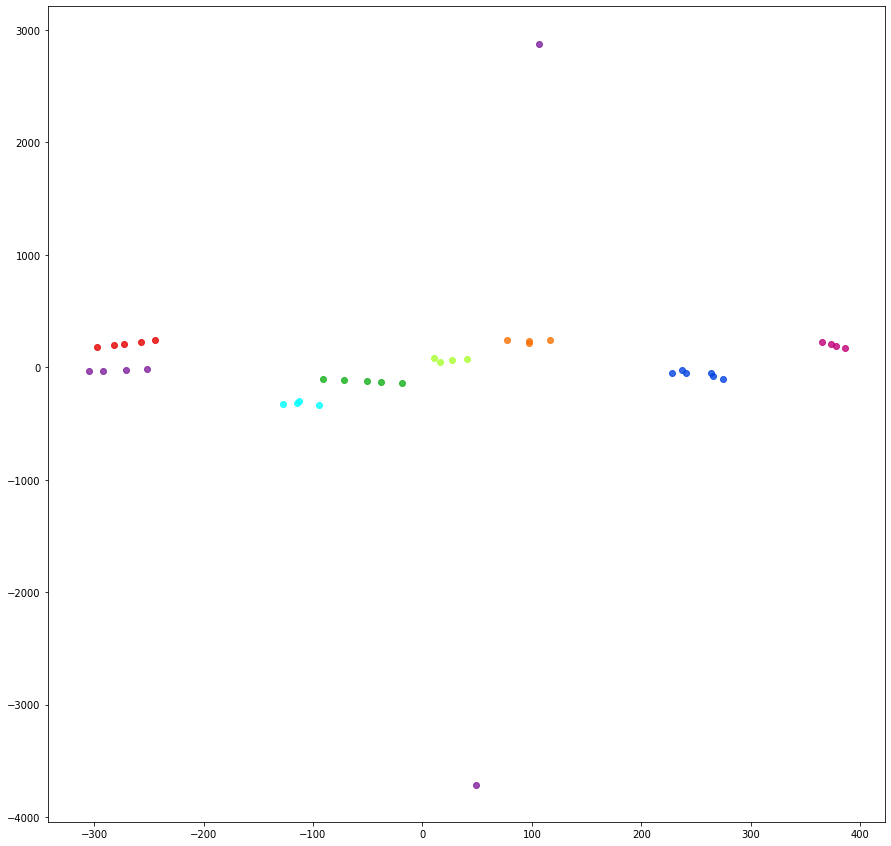

In [24]:
test = TSNE(perplexity=1).fit_transform(small_log_counts)
plot_cluster_data(test, small_data_labels, plot_label_type=False)

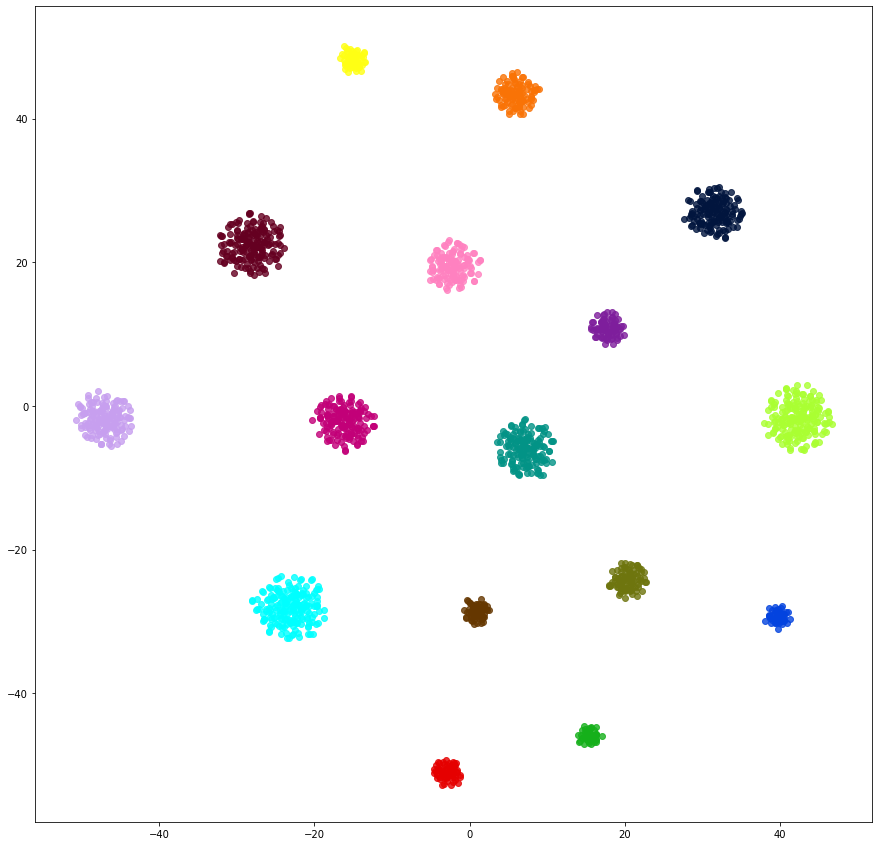

In [10]:
test = TSNE().fit_transform(large_log_counts)
plot_cluster_data(test, large_data_labels, plot_label_type=False)

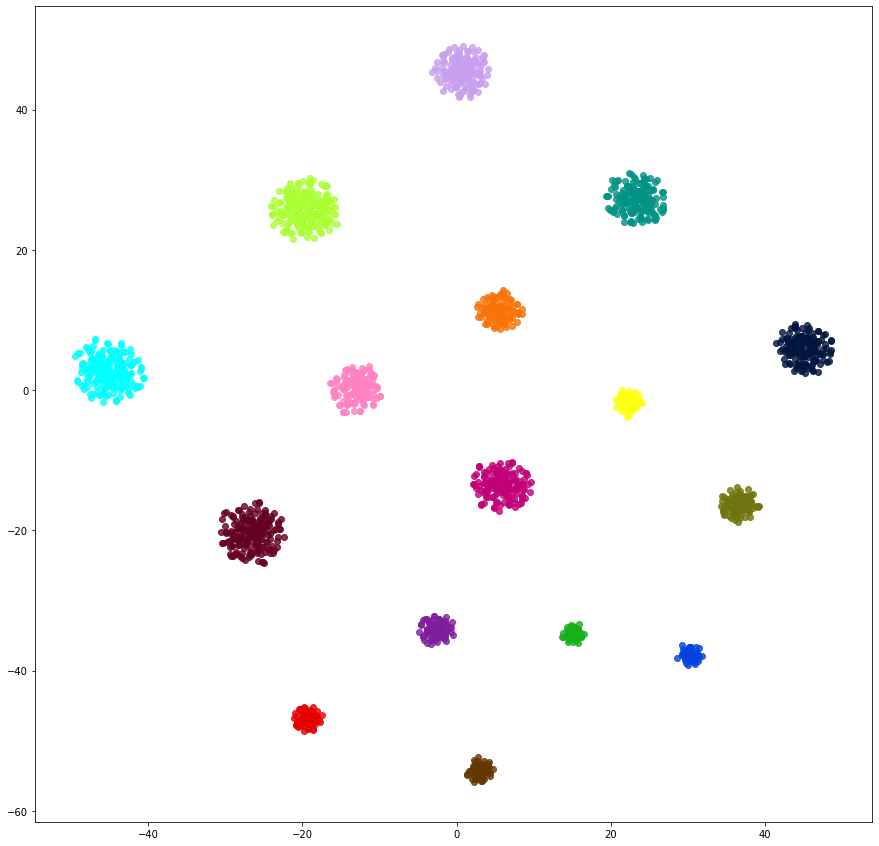

In [11]:
test = TSNE().fit_transform(large_log_counts)
plot_cluster_data(test, large_data_labels, plot_label_type=False)

In [12]:
np.log(np.NINF)

/home/zack/anaconda3/envs/mcb112/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan